# __Implementación de un modelo de Deep Learning__
__Momento de Retroalimentación Individual__

Frida Cano Falcón - A01752953

## Introducción

El reconocimiento facial, una tecnología emblemática del campo de la inteligencia artificial, ha experimentado avances significativos en los últimos años gracias al aprendizaje profundo (deep learning). Esta tecnología revolucionaria permite la identificación y autenticación de individuos a través del análisis de características faciales únicas y sutiles. Desde aplicaciones en la seguridad y la vigilancia hasta la autenticación biométrica en dispositivos móviles, el reconocimiento facial basado en deep learning ha transformado la forma en que interactuamos con el mundo digital y físico. Para abordar este desafío de manera efectiva, se recurre a técnicas de aprendizaje profundo, específicamente a las **redes neuronales convolucionales** (CNN, por sus siglas en inglés), que se han convertido en un estándar de referencia para la tarea de reconocimiento facial.

A lo largo de este informe, se presentará una visión general de la implementación de una CNN para el reconocimiento facial, se analizarán los conjuntos de datos utilizados, se describirán los ajustes del modelo y se evaluará su rendimiento. Este ejemplo servirá como una introducción práctica a la aplicación de técnicas de aprendizaje profundo en un contexto de reconocimiento facial y sentará las bases para comprender mejor las complejidades y desafíos asociados con esta emocionante área de investigación y desarrollo.


## Conexion con el directorio

Para iniciar con el desarrollo nos situamos en el directorio respectivo para almacenar información necesaria, en este caso almacenaremos los pesos y los resultados generados en el entrenamiento del modelo.

In [144]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [145]:
%cd "/content/drive/MyDrive/7mo Semestre/Deep Learning"
!pwd

/content/drive/MyDrive/Semestres/7mo Semestre/Deep Learning
/content/drive/MyDrive/Semestres/7mo Semestre/Deep Learning


## Importar librerías

En este apartado se busca implementar las librerías necesarias para el desarrollo de la red neuronal. __TensorFlow__ es una de las bibliotecas de código abierto más populares para la implementación de redes neuronales convolucionales (CNN) en tareas de clasificación. Las CNN son especialmente adecuadas para abordar problemas de clasificación de imágenes, como el reconocimiento de objetos, reconocimiento facial y segmentación de imágenes. Específicamente, Tensorflow y su API Keras permiten la creación de arquitecturas de CNN personalizadas mediante la definición de capas de convolución, capas de pooling, capas completamente conectadas y capas de salida. Los usuarios pueden personalizar el número de capas, el tamaño del kernel y otros hiperparámetros según las necesidades del problema.

In [146]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras import layers, optimizers
from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [147]:
# Clear any logs from previous runs
!rm -rf ./logs/

## Cargar data set
 Para este entrenamiento utilizamos, [Labeled Faces in the Wild](https://www.kaggle.com/datasets/atulanandjha/lfwpeople/data), una base de datos de fotografías faciales diseñada para estudiar el problema del reconocimiento facial sin restricciones. El conjunto de datos contiene más de 13,000 imágenes de caras recopiladas de la web. Cada cara ha sido etiquetada con el nombre de la persona retratada. 1680 de las personas retratadas tienen dos o más fotos distintas en el conjunto de datos. La única restricción en estas caras es que fueron detectadas por el detector de caras Viola-Jones. En efecto, las ventajas de utilizar LWF para el reconocimiento facial son que ofrece una amplitud y variedad de datos, datos etiquetados, diversidad de sujetos, condiciones de captura variada. Esto significa que el data set es robusto y que en consecuencia puede hacer que nuestra red lo sea.

In [148]:
# Cargar solamente las personas que tengan minimo 40 imagenes diferentes, radio de 0.1 para redimensionar las imagenes
lfw_people = fetch_lfw_people(min_faces_per_person=40, resize=1.0)

In [149]:
X = lfw_people.images

W = X.shape[1]
H = X.shape[2]
nchannel = 1 #gray image

# targets
y = lfw_people.target
#number of classses
nclasses = lfw_people.target_names.shape[0]

print("Número de clases: ",nclasses)

Número de clases:  19


División del data-set en datos de entrenamiento (80%) y testeo (20%).

In [150]:
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    stratify=y,
                                                    random_state=42)

Se plotean los ejemplos de rostros encontrados en el data-set.

<Figure size 640x480 with 0 Axes>

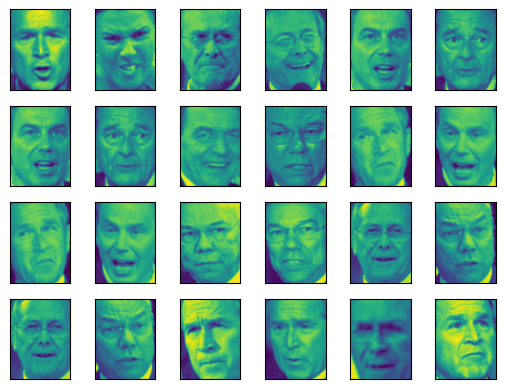

In [151]:
plt.figure(1)
figs, axes = plt.subplots(4, 6)
for i in range(4):
    for j in range(6):
        axes[i, j].imshow(x_train[i*4+j,:,:])
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
plt.show()

Normalización y asignación de clases

In [152]:
x_train = x_train.astype('float32')/255.0
x_test  = x_test.astype( 'float32')/255.0

y_train = to_categorical(y_train, nclasses)
y_test  = to_categorical(y_test, nclasses)

## Arquitectura de CNN

La siguiente red está diseñada para tareas de clasificación de imágenes y se puede personalizar ajustando parámetros como el tamaño de imagen de entrada, el número de clases (número de personas) y la tasa de aprendizaje. La capa de salida produce probabilidades de pertenencia a cada clase, lo que la hace adecuada para problemas de clasificación multicategórica. En este caso se busca generar un modelo que permita hacer un reconocimiento de rostros de un número de personas de una base de datos.

1. **Entrada**: La red comienza con una capa de entrada que espera tensores con una forma (W, H, nchannel), donde W y H representan el ancho y la altura de las imágenes de entrada, y nchannel representa el número de canales de color. Por defecto, se asume un tamaño de imagen de 32x32 y 3 canales (RGB).

2. **Capas Convolucionales**: A continuación, se definen tres capas convolucionales que extraen características de las imágenes. Cada capa utiliza un kernel de 3x3 y aplica la función de activación ReLU. Las capas convolucionales se encargan de aprender patrones y características de las imágenes de entrada. Las primeras dos capas están seguidas de capas de MaxPooling para reducir el tamaño espacial.

3. **Normalización por lotes**: Después de cada capa de convolución, se aplica una capa de normalización por lotes (BatchNormalization), lo que ayuda a acelerar el entrenamiento y a estabilizar el modelo.

4. **Capas de MaxPooling**: Después de cada par de capas convolucionales, se aplican capas de MaxPooling con un tamaño de ventana de 2x2. Esto reduce la dimensionalidad y permite que la red se enfoque en las características más importantes.

5. **Capas Completamente Conectadas**: Luego, se aplana la salida de las capas de MaxPooling en un vector unidimensional y se conecta a una capa completamente conectada (Dense) con 128 unidades y activación ReLU. Esta capa aprende a combinar las características extraídas de las capas convolucionales.

6. **Regularización**: Se aplica una capa de Dropout con una tasa del 60% para reducir el sobreajuste al desactivar aleatoriamente algunas neuronas durante el entrenamiento.

7. **Capa de Salida**: La capa de salida es otra capa completamente conectada con un número de unidades igual al número de clases (nclass) en el problema de clasificación. Utiliza una función de activación softmax para producir probabilidades de pertenencia a cada clase.

8. **Compilación del Modelo**: El modelo se compila especificando la función de pérdida (categorical_crossentropy), el optimizador (Adam) con una tasa de aprendizaje (lr) y la métrica de evaluación (precisión, en este caso).

Lo descrito anteriormente es la base de la red neuronal, sin embargo buscamos a través de transfer learning, mejorar la taza de precisión, modificando la arquitectura, agregando o evaluando los parámetros de las últimas capas de la red, obteniendo así los siquientes 3 modelos.

In [157]:
def baseline(model, W=32, H=32, nclass=10, nchannel=3, lr=1e-4):
  if model == 1:
    in1 = layers.Input(shape=(W, H, nchannel))
    x = layers.Conv2D(32, (3, 3), strides=(1, 1),
                      padding='valid',
                      activation='relu')(in1)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), strides=(1, 1),
                      padding='valid',
                      activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), strides=(1, 1),
                      padding='valid',
                      activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.55)(x)
    x = layers.Dense(128, activation='relu')(x)
    output = layers.Dense(nclass, activation='softmax')(x)
  elif model == 2:
    in1 = layers.Input(shape=(W, H, nchannel))
    x = layers.Conv2D(32, (3, 3), strides=(1, 1),
                      padding='valid',
                      activation='relu')(in1)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), strides=(1, 1),
                      padding='valid',
                      activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), strides=(1, 1),
                      padding='valid',
                      activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    output = layers.Dense(nclass, activation='softmax')(x)
  elif model == 3:
    in1 = layers.Input(shape=(W, H, nchannel))
    x = layers.Conv2D(32, (3, 3), strides=(1, 1),
                      padding='valid',
                      activation='relu')(in1)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), strides=(1, 1),
                      padding='valid',
                      activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), strides=(1, 1),
                      padding='valid',
                      activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    # x = layers.Dense(128, activation='relu')(x)
    output = layers.Dense(nclass, activation='softmax')(x)

  model = Model(inputs=in1, outputs=output)
  model.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(learning_rate=lr),
                metrics=['acc'])
  return model

## Entrenamiento de los modelos
La siguiente función sirve para poder entrenar los 3 modelos creados, con un batch, épocas y learning rate que se puede definir.

In [158]:
def entrenamiento(batch_size, epochs, lrate, nmodels):
  histories = []
  accs = []
  val_accs = []
  loss = []
  val_loss = []
  test_accs = []
  for i in range(nmodels):
    print(f'-------------------------------- MODEL {i+1} --------------------------------')
    # Creacion de modelo
    model_base = baseline(model=i+1,W=W, H=H, nclass=nclasses, nchannel=nchannel, lr=lrate)
    # model_base.summary()
    # Creacion de archivos para guardar resultados
    checkpoint_filepath = f'./checkpoints/checkpoint{i+1}.ckpt'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only = True,
    monitor = 'val_acc',
    mode = 'max',
    save_best_only = True)
    # # Entrenamiento
    history = model_base.fit(x_train,
                    y_train,
                    epochs = epochs,
                    batch_size = batch_size,
                    callbacks = [model_checkpoint_callback],
                    validation_split = 0.2,
                    verbose=True) # set verbose=True for monitoring epochs
    histories.append(history)
    # Resultados
    model_base.load_weights(checkpoint_filepath)
    test_loss,test_acc = model_base.evaluate(x_test,y_test)
    test_accs.append(test_acc)
    acc      = histories[i].history['acc']
    val_acc  = histories[i].history['val_acc']
    loss_     = histories[i].history['loss']
    val_loss_ = histories[i].history['val_loss']
    accs.append(acc)
    val_accs.append(val_acc)
    loss.append(loss_)
    val_loss.append(val_loss_)
  print("Test Accuracies: ",test_accs)
  return histories, accs, val_accs, loss, val_loss, test_accs

Se definen los hiperparámetros con los que se van a entrenar las diferentes arquitecturas. Es esta parte en donde el usuario puede editar los hiperparámetros para mejorar el comportamiento de la red.

In [159]:
# Hiper-parámetros
batch_size = 64
epochs     = 100
lrate      = 2e-4
nmodels = 3
histories, accs, val_accs, loss, val_loss, test_accs = entrenamiento(batch_size, epochs, lrate, nmodels)

-------------------------------- MODEL 1 --------------------------------
Epoch 1/100
19/19 [==============================] - 3s 43ms/step - loss: 2.6374 - acc: 0.2588 - val_loss: 2.9233 - val_acc: 0.2575
Epoch 2/100
19/19 [==============================] - 0s 22ms/step - loss: 2.3385 - acc: 0.3224 - val_loss: 2.9125 - val_acc: 0.2575
Epoch 3/100
19/19 [==============================] - 0s 23ms/step - loss: 2.0507 - acc: 0.3886 - val_loss: 2.9214 - val_acc: 0.2575
Epoch 4/100
19/19 [==============================] - 0s 23ms/step - loss: 1.6512 - acc: 0.5042 - val_loss: 2.9388 - val_acc: 0.0903
Epoch 5/100
19/19 [==============================] - 0s 21ms/step - loss: 1.3200 - acc: 0.6005 - val_loss: 2.9453 - val_acc: 0.0970
Epoch 6/100
19/19 [==============================] - 0s 23ms/step - loss: 1.0654 - acc: 0.6851 - val_loss: 2.9429 - val_acc: 0.1137
Epoch 7/100
19/19 [==============================] - 0s 23ms/step - loss: 0.8837 - acc: 0.7328 - val_loss: 2.9483 - val_acc: 0.0970
Ep

## Gráficado de resultados

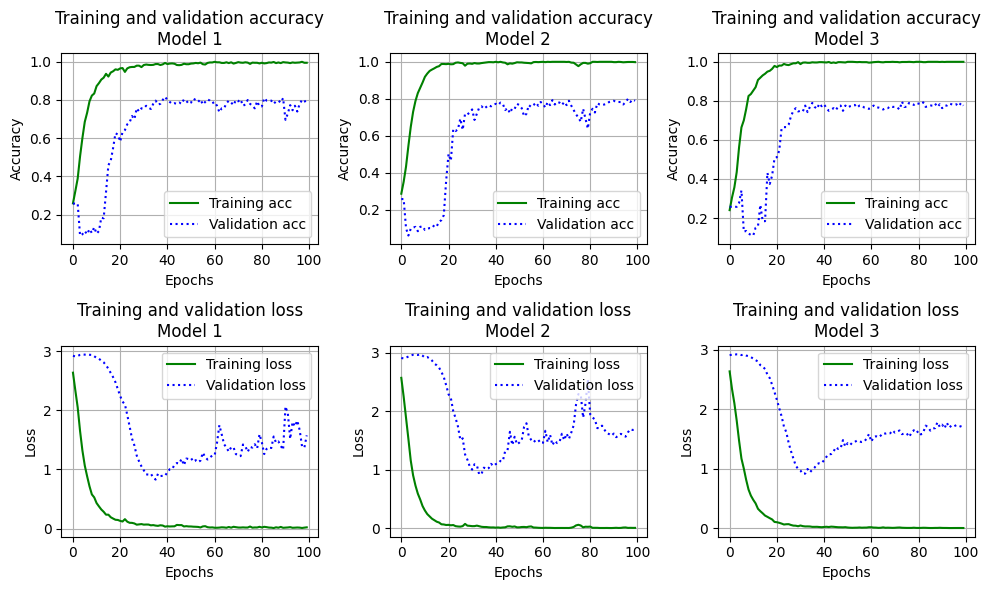

In [162]:
fig, axes = plt.subplots(2,3, figsize=(10,6))
for j in range(2):
  for k in range(nmodels):
    epochs = range(len(accs[k]))
    if j == 0:
      axes[j,k].plot(epochs, accs[k],'g', label='Training acc')
      axes[j,k].plot(epochs, val_accs[k], 'b:',label='Validation acc')
      axes[j,k].set_title(f'Training and validation accuracy\nModel {k+1}')
      axes[j,k].set_xlabel('Epochs')
      axes[j,k].set_ylabel('Accuracy')
      axes[j,k].grid(True)
      axes[j,k].legend()
    else:
      axes[j,k].plot(epochs, loss[k],     'g',  label='Training loss')
      axes[j,k].plot(epochs, val_loss[k], 'b:', label='Validation loss')
      axes[j,k].set_title(f'Training and validation loss\nModel {k+1}')
      axes[j,k].set_xlabel('Epochs')
      axes[j,k].set_ylabel('Loss')
      axes[j,k].grid(True)
      axes[j,k].legend()


# Ajustar el espaciado entre las subtramas
plt.tight_layout()
# Mostrar las gráficas
plt.show()

## Resultados

En las gráficas anteriores nos podemos ver las tazas tanto de precisión (accuracy) como de pérdida de validación (validation loss) en los tres diferentes modelos.

Sabemos que el valor de "validation loss" (pérdida de validación) en una red neuronal convolucional (CNN) es una métrica que proporciona información importante sobre el rendimiento del modelo durante la etapa de validación. La pérdida de validación es una medida de cuán bien el modelo generaliza a datos no vistos, es decir, a datos que no se utilizaron durante el entrenamiento.

En términos generales, el valor de la "validation loss" nos dice cuánto error comete el modelo al realizar predicciones en un conjunto de datos de validación, que generalmente es un subconjunto separado del conjunto de datos total.

Obtener un valor bajo de pérdida nos indica que el modelo está haciendo buenas predicciones. En esta aplicación, los valores de pérdida tienden a disminuir hasta casi 0 en la etapa de entrenamiento, sin embargo, en la etapa de validación al hacer un seguimiento vemos que a través del avance de las épocas, la pérdida converge a un valor aproximado de 1.5, esto nos puede estar indicando un sobreajuste (el modelo ha memorizado el conjunto de entrenamiento y se le complica adaptarse a patrines de datos diferentes).

Por otro lado, la taza de precisión mide la proporción de predicciones correctas realizadas por el modelo en un conjunto de datos, ya sea durante el entrenamiento o la validación. Un alto valor de precisión en la validación es un indicativo de que el modelo generaliza bien y es capaz de realizar predicciones precisas en nuevos ejemplos.

Al finalizar el entrenamiento obtenemos:
```
Test Accuracies:  [0.8074866533279419, 0.8048128485679626, 0.7941176295280457]
```
Estos valores nos pueden indicar un buen rendimiento de la red, no obstante, al tener una tasa de pérdida de validación alta el comportamiento de la red se pone en duda.

## Conclusiones

Es importante destacar que el rendimiento del modelo puede depender en gran medida de la calidad y cantidad de datos disponibles. Además, se debe prestar atención a la posibilidad de sobreajuste y se pueden explorar técnicas adicionales, como la recolección de más datos o la optimización de hiperparámetros, para mejorar aún más el rendimiento del modelo.

En resumen, la CNN desarrollada ha demostrado su capacidad para abordar la tarea de reconocimiento facial de manera efectiva. El uso del conjunto de datos LFW, junto con el diseño y ajuste adecuado de la arquitectura de la red, ha llevado a resultados alentadores. Este informe proporciona una visión general completa del proceso de desarrollo y evaluación del modelo, allanando el camino para su aplicación en aplicaciones prácticas de reconocimiento facial. Sin embargo, siempre es recomendable seguir explorando formas de mejorar y optimizar el modelo a medida que se presentan nuevos desafíos y oportunidades en el campo del aprendizaje profundo.

## Solución a la problemática de reconocimiento facial del reto
En lo que respecta al uso de aprendizaje profundo en la solución propuesta por el equipo para la solución del reto, buscamos un modelo preentrenado de detección y reconocimiento facial.  Se encontró una librería compatible con Python llamada *face_recognition* que se basa en el estado del arte de reconocimiento facial propuesto por la librería de C++  Dlib. Un feature que ofrece esta librería es el procesamiento de imágenes, en lo que concierne al reconocimiento facial los colaboradores de C++ generaron un modelo pre-entrenado de face recognition (*dlib_face_recognition_resnet_model_v1*) haciendo uso de aprendizaje profundo ofreciendo una tasa de precisión del 99.38% utilizando la base de datos de Labeled Faces in the Wild - LFW (Geitgey, 2020).

Esta librería nos otorga la precisión necesaria para tomar la asistencia en el aula. No se requiere de un modelo más robusto ya que el contexto del aula (poco movimiento, control del número de personas en la clase, condiciones de luz aproximadamente constantes) nos permite tener imágenes adecuadas para el proceso.

En el siguiente video el equipo desarrolla más afondo la solución planteada e implementada: https://youtu.be/WVavTEa8yoE